<a href="https://colab.research.google.com/github/amar9929-3/Bioinformatics_Project/blob/main/Notebooks/ML_Lee_Finished.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Setup and Imports

In [1]:
# If running on Colab, install anything missing
try:
    import umap
except Exception:
    %pip -q install umap-learn scikit-learn matplotlib pandas numpy

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Simulated Data

In [3]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
df = pd.read_csv('simulated_Lee.csv')
df.head()

Saving simulated_Lee.csv to simulated_Lee.csv


,Population,BMI,L_initial,a_initial,b_initial
0,APKO,1.271380,42.157942,2.458850,7.425322
1,ECKO,1.314798,48.600047,2.495276,11.921388
2,APHP,1.259317,42.813566,2.568835,8.388032
3,APKO,0.789212,40.373579,2.151550,11.039366
4,AMKO,1.066579,41.898043,2.508859,7.400798


## Train/Test Split

In [4]:
cols_to_drop = ['Population']
X = df.drop(columns=cols_to_drop)
y = df['Population']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

## Normalizing Data

In [5]:
col_to_log = ["BMI"]
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.drop(col_to_log)

def make_preprocess():
    return ColumnTransformer(
        transformers=[
            # Log + scale only this column
            (
                'log_scaled',
                Pipeline([
                    ('log', FunctionTransformer(np.log1p, validate=False)),
                    ('scale', StandardScaler())
                ]),
                col_to_log
            ),

            # Scale the remaining numeric columns normally
            (
                'scaled_numeric',
                StandardScaler(),
                numeric_cols
            )
        ],
        remainder='drop'
    )

# Running Unsupervised Methods for Visualization

## Log Tranform for Visualization

In [6]:
pre_vis = make_preprocess()
Xtr_proc = pre_vis.fit_transform(X_train)
Xte_proc = pre_vis.transform(X_test)

ytr = y_train.values
yte = y_test.values

## PCA

/tmp/ipython-input-2962134095.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)


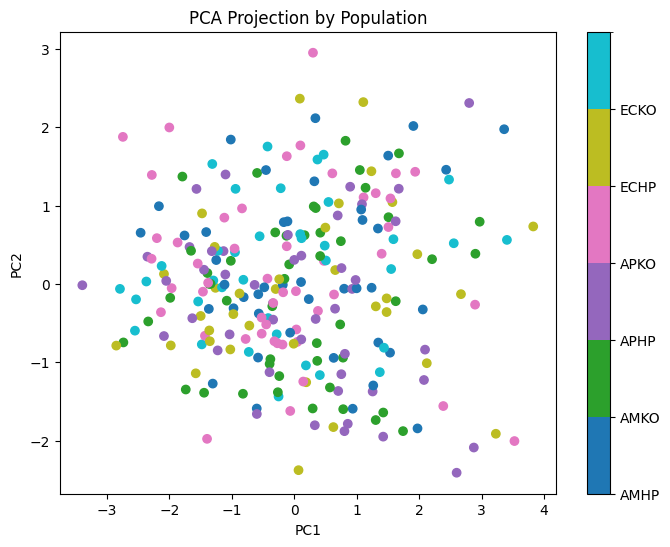

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# PCA
pca = PCA(n_components=2)
Xtr_pca = pca.fit_transform(Xtr_proc)
Xte_pca = pca.transform(Xte_proc)

# Encode labels
le = LabelEncoder()
ytr_encoded = le.fit_transform(ytr)

n_classes = len(le.classes_)

# Plot
plt.figure(figsize=(8,6))

# Discrete colormap
cmap = plt.cm.get_cmap('tab10', n_classes)
norm = mcolors.BoundaryNorm(range(n_classes + 1), cmap.N)

# Scatter the PCA projection
scatter = plt.scatter(Xtr_pca[:, 0], Xtr_pca[:, 1], c=ytr_encoded, cmap=cmap, norm=norm)

# Colorbar with proper class labels
cbar = plt.colorbar(scatter, ticks=range(n_classes))
cbar.ax.set_yticklabels(le.classes_)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection by Population")

plt.show()

## UMAP

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


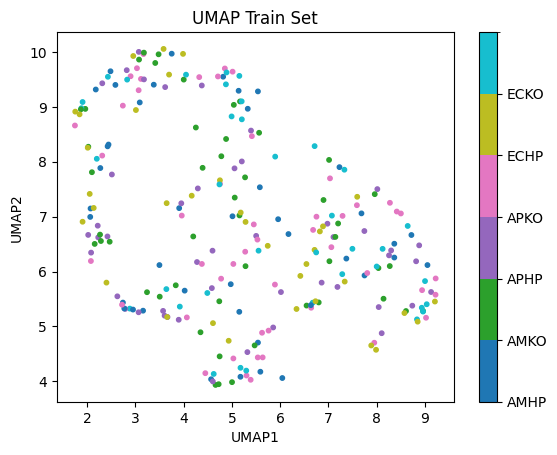

In [11]:
# UMAP
um = umap.UMAP(n_components=2, random_state=RANDOM_STATE, n_neighbors=15, min_dist=0.1)
UM_tr = um.fit_transform(Xtr_proc)
UM_te = um.transform(Xte_proc)

# Plot
plt.figure()
scatter = plt.scatter(UM_tr[:, 0], UM_tr[:, 1], c=ytr_encoded, cmap=cmap, norm=norm, s=10)
plt.title("UMAP Train Set")

cbar = plt.colorbar(scatter, ticks=range(n_classes))
cbar.ax.set_yticklabels(le.classes_)

plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

## t-SNE

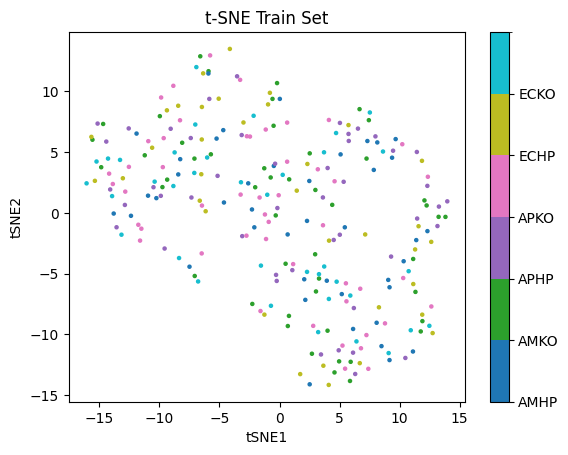

In [12]:
# t-SNE
ts = TSNE(n_components=2, random_state=RANDOM_STATE, init="pca", learning_rate="auto", perplexity=30)
TS_tr = ts.fit_transform(Xtr_proc)

# Plot
plt.figure()
scatter = plt.scatter(TS_tr[:,0], TS_tr[:,1], c=ytr_encoded, cmap=cmap, norm=norm, s=5)

cbar = plt.colorbar(scatter, ticks=range(n_classes))
cbar.ax.set_yticklabels(le.classes_)

plt.title("t-SNE Train Set")
plt.xlabel("tSNE1"); plt.ylabel("tSNE2")
plt.show()

# Build and Train Supervised Pipelines

In [13]:
models = {
    "LogReg": Pipeline([
        ("preprocess", make_preprocess()),
        ("clf", LogisticRegression(max_iter=500, multi_class="auto"))
    ]),

    "RF": Pipeline([
        ("preprocess", make_preprocess()),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=42))
    ]),

    "SVM": Pipeline([
        ("preprocess", make_preprocess()),
        ("clf", SVC(kernel='rbf', probability=True))
    ])
}


results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    proba = pipe.predict_proba(X_test)

    acc = accuracy_score(y_test, pred)

    try:
        auc = roc_auc_score(y_test, proba, multi_class="ovr")
    except:
        auc = np.nan

    results[name] = {"accuracy": acc, "roc_auc_ovr": auc}

results_df = pd.DataFrame(results).T
print("Baseline Train/Test Results")
print(results_df)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Baseline Train/Test Results
        accuracy  roc_auc_ovr
LogReg  0.130435     0.463543
RF      0.173913     0.496017
SVM     0.260870     0.495867


# Confusion Matrix of the Best Model

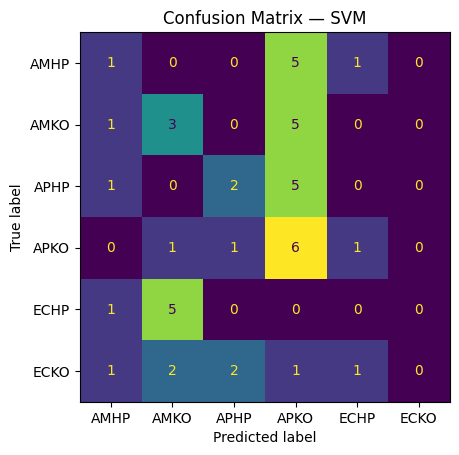

              precision    recall  f1-score   support

        APKO       0.20      0.14      0.17         7
        AMHP       0.27      0.33      0.30         9
        AMKO       0.40      0.25      0.31         8
        ECHP       0.27      0.67      0.39         9
        APHP       0.00      0.00      0.00         6
        ECKO       0.00      0.00      0.00         7

    accuracy                           0.26        46
   macro avg       0.19      0.23      0.19        46
weighted avg       0.21      0.26      0.21        46



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
best = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_pipe = models[best]
pred = best_pipe.predict(X_test)

disp = ConfusionMatrixDisplay(confusion_matrix(y_test, pred), display_labels=sorted(y_test.unique()))
fig, ax = plt.subplots()
disp.plot(ax=ax, colorbar=False)
plt.title(f"Confusion Matrix — {best}")
plt.show()

print(classification_report(y_test, pred, target_names=y_test.unique()))

# Cross-Validate Training

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = {
    "LogReg": {"clf__C":[0.1,1,10]},
    "RF":     {"clf__n_estimators":[200,400], "clf__max_depth":[None,10]},
    "SVM":    {"clf__C":[0.5,1,2], "clf__gamma":["scale","auto"]},
}

tuned = {}
for name, pipe in models.items():
    grid_pipe = Pipeline([
      ("preprocess", make_preprocess()),
      ("clf", pipe.named_steps["clf"])
    ])

    grid = GridSearchCV(grid_pipe, param_grid[name], cv=cv, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)
    tuned[name] = {"best_score": grid.best_score_, "best_params": grid.best_params_, "estimator": grid.best_estimator_}

pd.DataFrame({k: {"cv_best_acc": v["best_score"], **v["best_params"]} for k,v in tuned.items()}).T

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,cv_best_acc,clf__C,clf__max_depth,clf__n_estimators,clf__gamma
LogReg,0.139894,0.1,NaN,NaN,NaN
RF,0.159201,NaN,NaN,400.0,NaN
SVM,0.159427,0.5,NaN,NaN,scale


# ROC Curves

<Figure size 640x480 with 0 Axes>

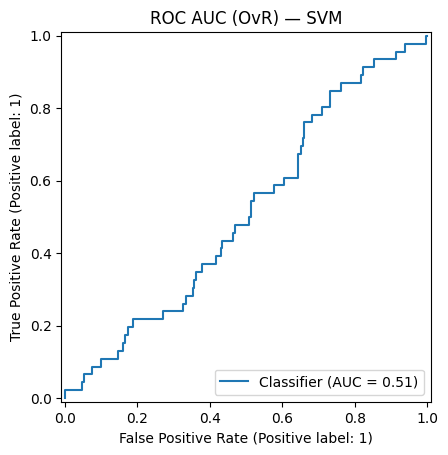

In [16]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

best_name = max(tuned.items(), key=lambda kv: kv[1]["best_score"])[0]
est = tuned[best_name]["estimator"].fit(X_train, y_train)
y_score = est.predict_proba(X_test)

y_bin = label_binarize(y_test, classes=np.unique(y_train))
fig = plt.figure()
RocCurveDisplay.from_predictions(y_bin.ravel(), y_score.ravel())
plt.title(f"ROC AUC (OvR) — {best_name}")
plt.show()

# Trained Color Coded UMAP

/tmp/ipython-input-3767959095.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', n_classes)
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


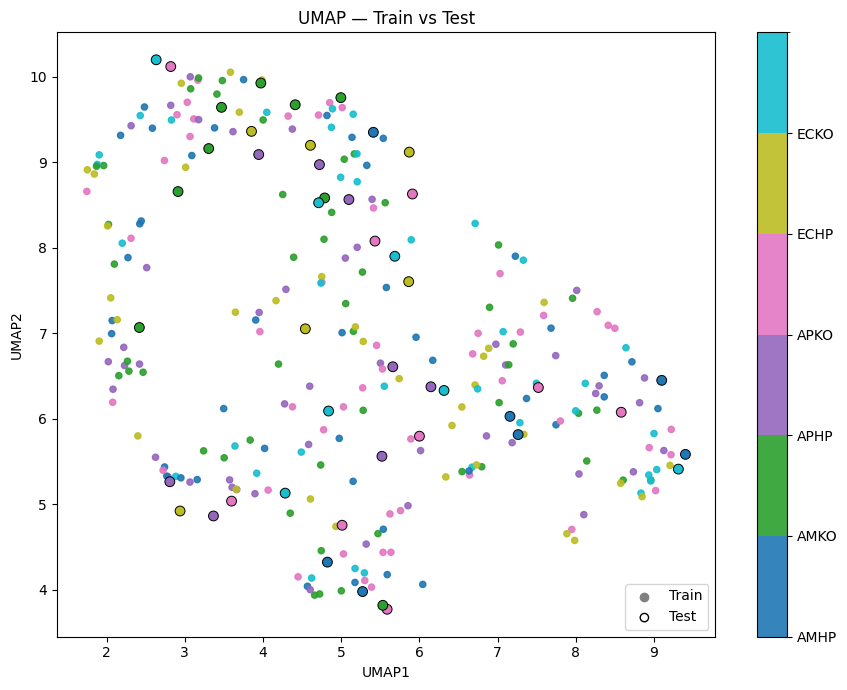

In [19]:
# Encode labels
le = LabelEncoder()
ytr_enc = le.fit_transform(y_train)
yte_enc = le.transform(y_test)
n_classes = len(le.classes_)

# Discrete colormap
cmap = plt.cm.get_cmap('tab10', n_classes)
norm = mcolors.BoundaryNorm(range(n_classes+1), cmap.N)

# Fit UMAP
um_vis = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
UM_tr = um_vis.fit_transform(Xtr_proc)
UM_te = um_vis.transform(Xte_proc)

plt.figure(figsize=(9,7))

# TRAIN (solid markers)
scatter_tr = plt.scatter(UM_tr[:,0], UM_tr[:,1], c=ytr_enc, cmap=cmap, norm=norm, s=20, alpha=0.9)

# TEST (hollow markers)
scatter_te = plt.scatter(UM_te[:,0], UM_te[:,1], c=yte_enc, cmap=cmap, norm=norm, s=50, alpha=1.0, facecolors='none', edgecolors='k', linewidths=0.7)

# CLASS LEGEND (population names)
handles = []
for i, cls in enumerate(le.classes_):
    handles.append(
        plt.Line2D(
            [], [],
            marker='o', linestyle='',
            markersize=8,
            markerfacecolor=cmap(i),
            markeredgecolor='k',
            label=cls
        )
    )

plt.legend(
    handles=handles,
    title="Population",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Train/Test legend
plt.scatter([], [], marker='o', color='gray', label='Train')
plt.scatter([], [], marker='o', facecolors='none', edgecolors='k', label='Test')
plt.legend(loc='lower right')

# Colorbar
cbar = plt.colorbar(scatter_tr, ticks=range(n_classes))
cbar.ax.set_yticklabels(le.classes_)

plt.title("UMAP — Train vs Test")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

plt.tight_layout()
plt.show()

# Final Analysis with Most Accurate Classifier

## Real Data

In [20]:
from google.colab import files
uploaded = files.upload()

import pandas as pd
dn = pd.read_csv('Lee_3.1.csv')
dn.head()

Saving Lee_3.1.csv to Lee_3.1.csv


,Population,BMI,L_initial,a_initial,b_initial
0,AMKO,0.913762,38.884693,2.683471,6.598326
1,AMKO,1.094209,43.968150,3.999215,9.271493
2,AMKO,0.781206,40.054521,3.502004,6.794818
3,AMKO,0.826641,40.239022,2.641676,16.246835
4,AMKO,0.773668,39.304593,3.790041,13.870430


## Split Real Data

In [21]:
X_new = dn.drop(columns=cols_to_drop)
y_new = dn['Population']

sample = X_new.sample(frac=0.15, random_state=42)
X_15 = sample
y_15 = y_new.loc[sample.index]

## Most Accurate Classifier

In [22]:
# Choose Most Accurate Classifier
best_name = max(results.items(), key=lambda kv: kv[1]["accuracy"])[0]
best_pipe = models[best_name]

print("Best model from training:", best_name)

pred_new = best_pipe.predict(X_new)
proba_new = best_pipe.predict_proba(X_new)

# Evaluation table
if y_new is not None:
    acc = accuracy_score(y_new, pred_new)
    try:
        auc = roc_auc_score(y_new, proba_new, multi_class="ovr")
    except:
        auc = np.nan
else:
    acc = np.nan
    auc = np.nan

results_new_df = pd.DataFrame({
    best_name: {
        "accuracy": acc,
        "roc_auc_ovr": auc
    }
}).T

print("Real Data Results (Best Model Only)")
print(results_new_df)

Best model from training: SVM
Real Data Results (Best Model Only)
     accuracy  roc_auc_ovr
SVM  0.151815      0.50261
